<a href="https://colab.research.google.com/github/24521586-Tan/IT002_OOP_UIT/blob/main/contrastive_learning_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo Contrastive Learning - SimCLR
# (Học Tương Phản)

---

## Giới thiệu

Notebook này minh họa các khái niệm cốt lõi của **Contrastive Learning**:

| Thành phần | Mô tả |
|------------|-------|
| **Data Augmentation** | Tạo cặp tích cực (Positive Pairs) từ cùng một ảnh |
| **Encoder f(x)** | Trích xuất đặc trưng h từ ảnh đầu vào |
| **Projection Head g(h)** | Chiếu h sang không gian embedding z |
| **InfoNCE Loss** | Hàm mất mát tương phản - kéo gần positive, đẩy xa negative |

---

### Nguyên lý hoạt động:

```
Ảnh gốc x --> [Augmentation] --> x_i, x_j (Positive Pair)
                                    |
                              [Encoder f]
                                    |
                              h_i, h_j (Features)
                                    |
                          [Projection Head g]
                                    |
                              z_i, z_j (Embeddings)
                                    |
                            [InfoNCE Loss]
                                    |
                    Kéo z_i, z_j lại GẦN nhau
                    Đẩy các z khác ra XA
```

In [ ]:
# === IMPORT THƯ VIỆN ===
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Kiểm tra GPU có sẵn không
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Thiết bị sử dụng: {device}")

Thiết bị sử dụng: cuda


---
## 1. Data Augmentation - Tăng cường dữ liệu

### Khái niệm chính:
- Từ **1 ảnh gốc**, tạo ra **2 phiên bản biến đổi khác nhau** = **Positive Pair** (Cặp tích cực)
- Mô hình phải học: 2 view này là **CÙNG** một ảnh!

### Các phép biến đổi sử dụng:
- `RandomResizedCrop`: Cắt ngẫu nhiên
- `ColorJitter`: Biến đổi màu sắc (**rất quan trọng!**)
- `GaussianBlur`: Làm mờ
- `RandomHorizontalFlip`: Lật ngang ngẫu nhiên

In [ ]:
class SimCLRAugmentation:
    """
    Lớp tăng cường dữ liệu cho SimCLR.

    Mục đích: Tạo 2 phiên bản (views) khác nhau từ cùng 1 ảnh
    để tạo thành Positive Pair.
    """
    def __init__(self, img_size=32):
        # Định nghĩa chuỗi các phép biến đổi
        self.transform = transforms.Compose([
            # Cắt ngẫu nhiên và resize về kích thước mong muốn
            transforms.RandomResizedCrop(img_size, scale=(0.2, 1.0)),

            # Lật ngang với xác suất 50%
            transforms.RandomHorizontalFlip(p=0.5),

            # Biến đổi màu sắc (Color Jitter) - QUAN TRỌNG!
            # Giúp mô hình không "ăn gian" bằng cách nhớ histogram màu
            transforms.RandomApply([
                transforms.ColorJitter(
                    brightness=0.4,  # Độ sáng
                    contrast=0.4,    # Độ tương phản
                    saturation=0.4,  # Độ bão hòa
                    hue=0.1          # Tông màu
                )
            ], p=0.8),

            # Chuyển sang ảnh xám với xác suất 20%
            transforms.RandomGrayscale(p=0.2),

            # Làm mờ Gaussian
            transforms.GaussianBlur(kernel_size=3),

            # Chuyển sang tensor và chuẩn hóa
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # Giá trị trung bình ImageNet
                std=[0.229, 0.224, 0.225]    # Độ lệch chuẩn ImageNet
            )
        ])

    def __call__(self, x):
        """
        Tạo 2 views khác nhau từ cùng 1 ảnh.

        Args:
            x: Ảnh gốc (PIL Image)

        Returns:
            view_1, view_2: Hai phiên bản biến đổi (Positive Pair)
        """
        view_1 = self.transform(x)  # Phiên bản 1 (x_i)
        view_2 = self.transform(x)  # Phiên bản 2 (x_j)
        return view_1, view_2

### Minh họa Data Augmentation

Files already downloaded and verified


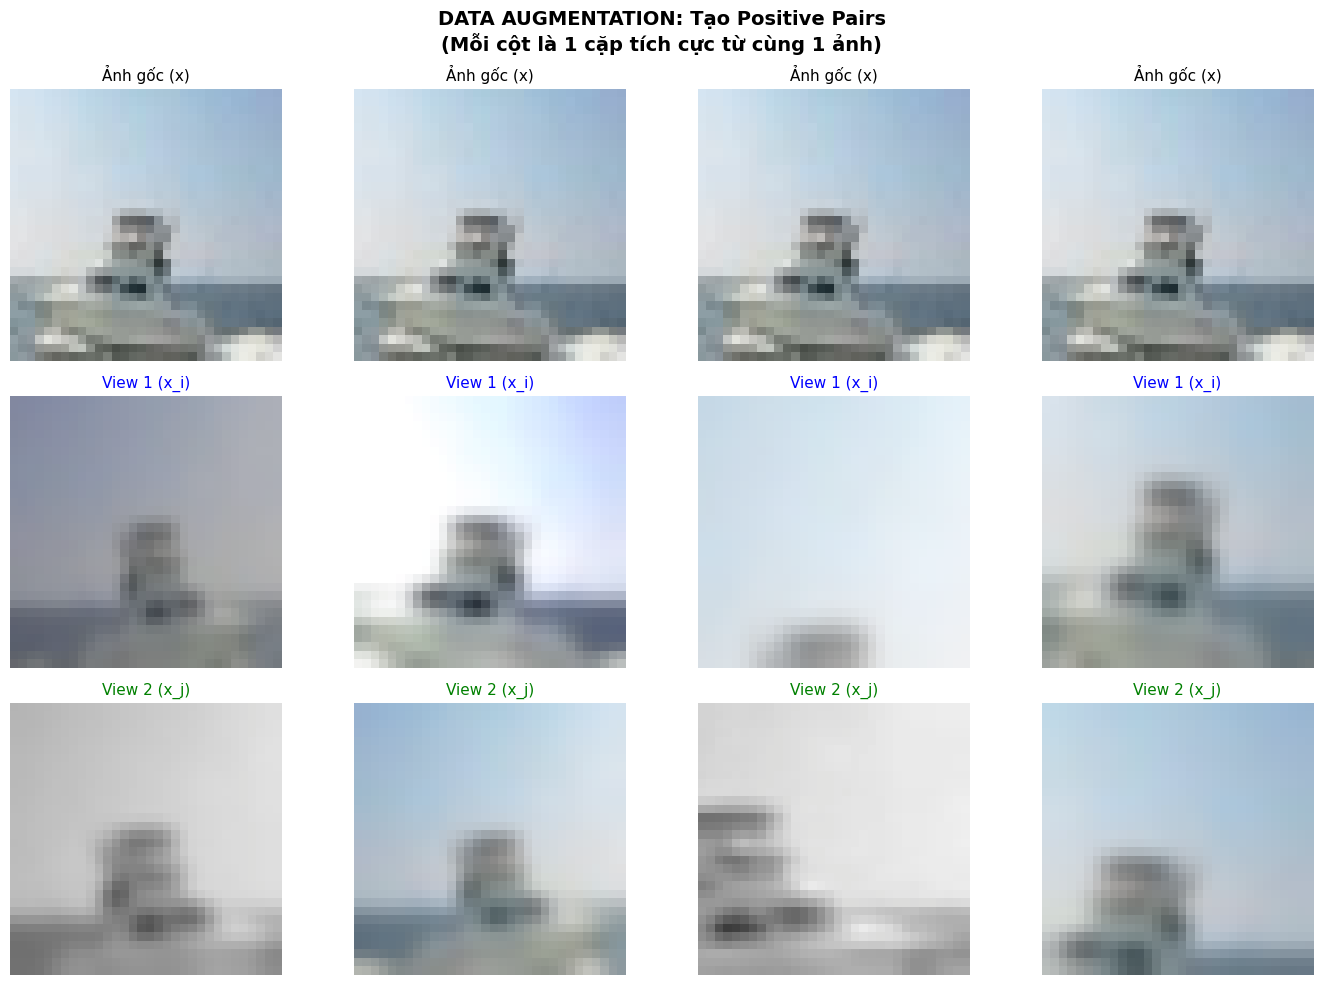

POSITIVE PAIR: View 1 và View 2 trong cùng 1 cột
Mô hình phải học: chúng là CÙNG một ảnh!


In [ ]:
# Tải dataset CIFAR-10 để lấy ảnh mẫu
sample_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
sample_img, label = sample_dataset[100]  # Lấy ảnh thứ 100

# Tạo đối tượng augmentation
aug = SimCLRAugmentation(img_size=32)

def denormalize(tensor):
    """Chuyển tensor đã chuẩn hóa về ảnh hiển thị được"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return torch.clamp(tensor * std + mean, 0, 1)

# Hiển thị ảnh gốc và các cặp augmented
fig, axes = plt.subplots(3, 4, figsize=(14, 10))
fig.suptitle('DATA AUGMENTATION: Tạo Positive Pairs\n(Mỗi cột là 1 cặp tích cực từ cùng 1 ảnh)',
             fontsize=14, fontweight='bold')

# Hàng đầu: Ảnh gốc
for i in range(4):
    axes[0, i].imshow(sample_img)
    axes[0, i].set_title('Ảnh gốc (x)', fontsize=11)
    axes[0, i].axis('off')

# Hàng 2 và 3: Các cặp augmented
for i in range(4):
    view_1, view_2 = aug(sample_img)

    axes[1, i].imshow(denormalize(view_1).permute(1, 2, 0))
    axes[1, i].set_title(f'View 1 (x_i)', fontsize=11, color='blue')
    axes[1, i].axis('off')

    axes[2, i].imshow(denormalize(view_2).permute(1, 2, 0))
    axes[2, i].set_title(f'View 2 (x_j)', fontsize=11, color='green')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

print("="*60)
print("POSITIVE PAIR: View 1 và View 2 trong cùng 1 cột")
print("Mô hình phải học: chúng là CÙNG một ảnh!")
print("="*60)

---
## 2. Encoder f(x) - Bộ mã hóa

### Chức năng:
Trích xuất vector đặc trưng **h** từ ảnh đầu vào.

$$h = f(x)$$

### Trong thực tế:
- Thường dùng **ResNet-50** hoặc **ViT**
- Demo này dùng CNN đơn giản để dễ hiểu

### Lưu ý quan trọng:
**h được sử dụng cho downstream tasks** (phân loại, phát hiện vật thể, ...)

In [ ]:
class Encoder(nn.Module):
    """
    Bộ mã hóa (Encoder) f(x) -> h

    Chức năng: Trích xuất đặc trưng từ ảnh đầu vào
    Đầu vào: Ảnh x (batch_size, 3, 32, 32)
    Đầu ra: Vector đặc trưng h (batch_size, feature_dim)
    """
    def __init__(self, feature_dim=512):
        super().__init__()

        # Các lớp tích chập để trích xuất đặc trưng
        self.conv_layers = nn.Sequential(
            # Lớp 1: 3 -> 32 channels
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),      # Chuẩn hóa batch
            nn.ReLU(),               # Hàm kích hoạt
            nn.MaxPool2d(2),         # Giảm kích thước 1/2

            # Lớp 2: 32 -> 64 channels
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Lớp 3: 64 -> 128 channels
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Global Average Pooling
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Lớp fully connected cuối cùng
        self.fc = nn.Linear(128, feature_dim)

    def forward(self, x):
        """
        Lan truyền xuôi (Forward pass)

        Args:
            x: Ảnh đầu vào (batch_size, 3, H, W)

        Returns:
            h: Vector đặc trưng (batch_size, feature_dim)
        """
        x = self.conv_layers(x)        # Trích xuất đặc trưng
        x = x.view(x.size(0), -1)      # Làm phẳng (flatten)
        h = self.fc(x)                 # h = f(x)
        return h

---
## 3. Projection Head g(h) - Đầu chiếu

### Chức năng:
Chiếu vector đặc trưng **h** sang không gian embedding **z** để tính loss.

$$z = g(h)$$

### Điểm quan trọng:
- Loss được tính trên **z** (tốt hơn tính trên h)
- Sau khi training xong, **BỎ g(.)** đi!
- Chỉ giữ lại **f(.)** cho downstream tasks

In [ ]:
class ProjectionHead(nn.Module):
    """
    Đầu chiếu (Projection Head) g(h) -> z

    Chức năng: Chiếu features h sang không gian embedding z

    LƯU Ý: Sau khi huấn luyện xong, ta VỨT BỎ projection head này!
           Chỉ giữ lại Encoder để dùng cho downstream tasks.
    """
    def __init__(self, input_dim=512, hidden_dim=256, output_dim=128):
        super().__init__()

        # MLP 2 lớp với activation phi tuyến
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),   # Lớp ẩn
            nn.ReLU(),                          # Phi tuyến
            nn.Linear(hidden_dim, output_dim)   # Lớp đầu ra
        )

    def forward(self, h):
        """
        Args:
            h: Vector đặc trưng từ Encoder (batch_size, input_dim)

        Returns:
            z: Embedding vector (batch_size, output_dim)
        """
        z = self.mlp(h)  # z = g(h)
        return z

---
## 4. Mô hình SimCLR hoàn chỉnh

```
Ảnh x --> [Encoder f] --> h --> [Projection Head g] --> z
```

In [ ]:
class SimCLR(nn.Module):
    """
    Mô hình SimCLR hoàn chỉnh.

    Kiến trúc:
        x --> Encoder f(x) --> h --> Projection Head g(h) --> z

    Trong đó:
        - f: Encoder (trích xuất đặc trưng)
        - g: Projection Head (chiếu sang embedding space)
        - h: Feature representation (dùng cho downstream)
        - z: Embedding (dùng để tính loss)
    """
    def __init__(self, feature_dim=512, projection_dim=128):
        super().__init__()

        # Encoder f(.)
        self.encoder = Encoder(feature_dim)

        # Projection Head g(.)
        self.projection_head = ProjectionHead(
            input_dim=feature_dim,
            output_dim=projection_dim
        )

    def forward(self, x):
        """
        Args:
            x: Ảnh đầu vào (batch_size, 3, H, W)

        Returns:
            h: Feature representation (cho downstream tasks)
            z: Embedding (cho contrastive loss)
        """
        h = self.encoder(x)           # h = f(x) - Đặc trưng
        z = self.projection_head(h)   # z = g(h) - Embedding
        return h, z


# Khởi tạo mô hình
model = SimCLR(feature_dim=512, projection_dim=128).to(device)

print("KIẾN TRÚC MÔ HÌNH SIMCLR:")
print("="*50)
print(model)
print("="*50)

# Đếm số tham số
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTổng số tham số: {total_params:,}")

KIẾN TRÚC MÔ HÌNH SIMCLR:
SimCLR(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): AdaptiveAvgPool2d(output_size=(1, 1))
    )
    (fc): Linear(in_features=128, out_features=512, bias=True)
  )
  (projection_head): ProjectionHead(
    (mlp): Sequential

---
## 5. InfoNCE Loss - Hàm mất mát tương phản

### Đây là TRÁI TIM của Contrastive Learning!

### Công thức:

$$L_{ij} = -\log \frac{\exp(sim(z_i, z_j)/\tau)}{\sum_{k \neq i} \exp(sim(z_i, z_k)/\tau)}$$

### Giải thích:
| Thành phần | Ý nghĩa |
|------------|--------|
| **Tử số** | Độ tương đồng của cặp POSITIVE (kéo lại gần) |
| **Mẫu số** | Tổng độ tương đồng với TẤT CẢ mẫu khác (đẩy ra xa) |
| **τ (temperature)** | Điều chỉnh độ "sắc nét" của phân phối |
| **sim(u,v)** | Cosine similarity = u·v / (\|u\|·\|v\|) |

### Cơ chế:
- **Kéo gần (Pull):** Các điểm positive pairs
- **Đẩy xa (Push):** Các điểm negative pairs

In [ ]:
class InfoNCELoss(nn.Module):
    """
    Hàm mất mát InfoNCE (còn gọi là NT-Xent Loss).

    Nguyên lý:
        - KÉO GẦN các cặp positive (cùng ảnh, khác augmentation)
        - ĐẨY XA các cặp negative (khác ảnh)

    Công thức:
        L_ij = -log( exp(sim(z_i, z_j)/T) / sum_k(exp(sim(z_i, z_k)/T)) )
    """
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature  # Tham số nhiệt độ τ

    def forward(self, z_i, z_j):
        """
        Tính InfoNCE Loss.

        Args:
            z_i: Embeddings từ view 1 (batch_size, projection_dim)
            z_j: Embeddings từ view 2 (batch_size, projection_dim)

        Returns:
            loss: Giá trị loss trung bình
        """
        batch_size = z_i.shape[0]

        # Bước 1: Chuẩn hóa vectors (cho cosine similarity)
        z_i = F.normalize(z_i, dim=1)  # ||z_i|| = 1
        z_j = F.normalize(z_j, dim=1)  # ||z_j|| = 1

        # Bước 2: Ghép nối z_i và z_j
        # z = [z_i; z_j] có shape (2*batch_size, projection_dim)
        z = torch.cat([z_i, z_j], dim=0)

        # Bước 3: Tính ma trận similarity
        # sim_matrix[a,b] = sim(z_a, z_b) / temperature
        # Shape: (2*batch_size, 2*batch_size)
        sim_matrix = torch.mm(z, z.t()) / self.temperature

        # Bước 4: Tạo mask để loại bỏ self-similarity (so sánh với chính nó)
        mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
        sim_matrix = sim_matrix.masked_fill(mask, -float('inf'))

        # Bước 5: Tạo labels cho positive pairs
        # Với mẫu i, positive của nó ở vị trí i + batch_size
        # Với mẫu i + batch_size, positive của nó ở vị trí i
        labels = torch.cat([
            torch.arange(batch_size, 2 * batch_size),  # [N, N+1, ..., 2N-1]
            torch.arange(batch_size)                    # [0, 1, ..., N-1]
        ], dim=0).to(z.device)

        # Bước 6: Tính Cross Entropy Loss
        # Đây chính là InfoNCE Loss!
        loss = F.cross_entropy(sim_matrix, labels)

        return loss


# Khởi tạo loss function
criterion = InfoNCELoss(temperature=0.5)
print("Đã khởi tạo InfoNCE Loss với temperature = 0.5")

Đã khởi tạo InfoNCE Loss với temperature = 0.5


---
## 6. Huấn luyện SimCLR

### Quy trình:
1. Lấy batch ảnh từ dataset
2. Tạo 2 views cho mỗi ảnh (Data Augmentation)
3. Đưa qua Encoder và Projection Head
4. Tính InfoNCE Loss
5. Backpropagation và cập nhật weights

In [ ]:
# === CHUẨN BỊ DỮ LIỆU ===

# Tải CIFAR-10 với SimCLR augmentation
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=SimCLRAugmentation(img_size=32)  # Trả về (view_1, view_2)
)

# DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=256,       # Batch size (SimCLR cần batch lớn!)
    shuffle=True,         # Xáo trộn dữ liệu
    num_workers=0,
    drop_last=True        # Bỏ batch cuối nếu không đủ
)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"Số lượng mẫu: {len(train_dataset)}")
print(f"Số batch mỗi epoch: {len(train_loader)}")
print(f"Batch size: 256")

Files already downloaded and verified
Số lượng mẫu: 50000
Số batch mỗi epoch: 195
Batch size: 256


In [ ]:
# === VÒNG LẶP HUẤN LUYỆN ===

epochs = 3  # Số epoch (tăng lên cho kết quả tốt hơn)
losses = []

print("="*60)
print("BẮT ĐẦU HUẤN LUYỆN SIMCLR")
print("="*60)
print("Mục tiêu: Kéo Positive Pairs LẠI GẦN, đẩy Negatives RA XA")
print("-"*60)

model.train()  # Chế độ training

for epoch in range(epochs):
    epoch_loss = 0

    for batch_idx, ((view_1, view_2), _) in enumerate(train_loader):
        # Di chuyển dữ liệu sang device (GPU/CPU)
        view_1 = view_1.to(device)  # View 1 của batch
        view_2 = view_2.to(device)  # View 2 của batch

        # === FORWARD PASS ===
        # Đưa cả 2 views qua mô hình
        h_i, z_i = model(view_1)  # h_i = f(x_i), z_i = g(h_i)
        h_j, z_j = model(view_2)  # h_j = f(x_j), z_j = g(h_j)

        # === TÍNH LOSS ===
        # InfoNCE Loss: kéo z_i, z_j lại gần, đẩy các z khác ra xa
        loss = criterion(z_i, z_j)

        # === BACKWARD PASS ===
        optimizer.zero_grad()  # Reset gradients
        loss.backward()        # Tính gradients
        optimizer.step()       # Cập nhật weights

        epoch_loss += loss.item()

        # In tiến trình
        if batch_idx % 50 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Batch [{batch_idx:3d}/{len(train_loader)}] | Loss: {loss.item():.4f}")

    # Tính loss trung bình của epoch
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    print("-"*60)
    print(f">>> EPOCH [{epoch+1}/{epochs}] HOÀN THÀNH | Loss trung bình: {avg_loss:.4f}")
    print("-"*60)

print("\nHUẤN LUYỆN HOÀN TẤT!")

BẮT ĐẦU HUẤN LUYỆN SIMCLR
Mục tiêu: Kéo Positive Pairs LẠI GẦN, đẩy Negatives RA XA
------------------------------------------------------------
Epoch [1/3] | Batch [  0/195] | Loss: 6.1372
Epoch [1/3] | Batch [ 50/195] | Loss: 5.3313
Epoch [1/3] | Batch [100/195] | Loss: 5.2203
Epoch [1/3] | Batch [150/195] | Loss: 5.1801
------------------------------------------------------------
>>> EPOCH [1/3] HOÀN THÀNH | Loss trung bình: 5.3127
------------------------------------------------------------
Epoch [2/3] | Batch [  0/195] | Loss: 5.1884
Epoch [2/3] | Batch [ 50/195] | Loss: 5.1277
Epoch [2/3] | Batch [100/195] | Loss: 5.1668
Epoch [2/3] | Batch [150/195] | Loss: 5.0654
------------------------------------------------------------
>>> EPOCH [2/3] HOÀN THÀNH | Loss trung bình: 5.1230
------------------------------------------------------------
Epoch [3/3] | Batch [  0/195] | Loss: 5.1215
Epoch [3/3] | Batch [ 50/195] | Loss: 5.0498
Epoch [3/3] | Batch [100/195] | Loss: 5.0645
Epoch [3/3

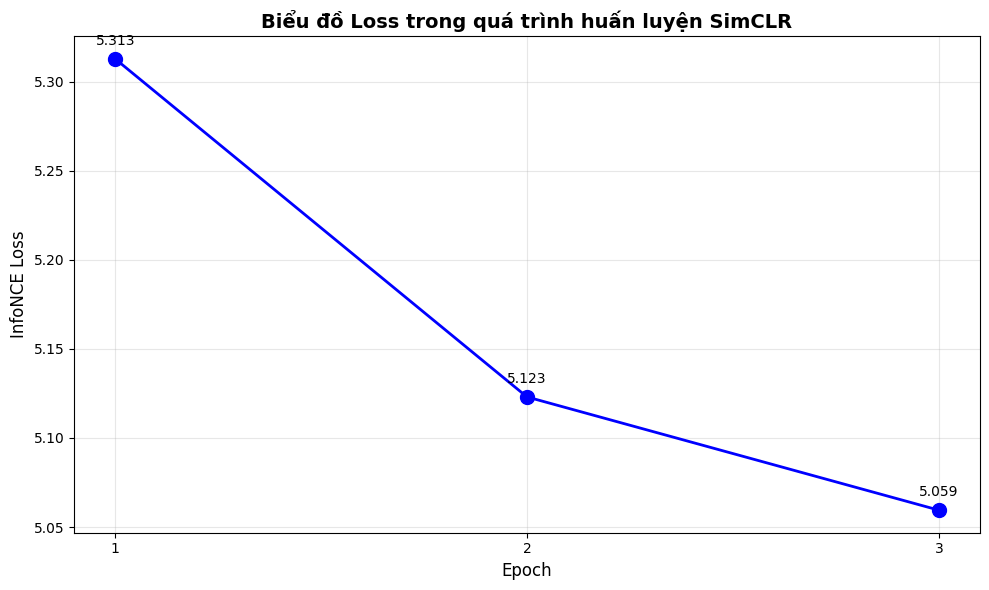


Loss giảm từ 5.3127 xuống 5.0595
=> Mô hình đang học cách phân biệt positive và negative pairs!


In [ ]:
# === VẼ BIỂU ĐỒ LOSS ===

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, 'b-o', linewidth=2, markersize=10)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('InfoNCE Loss', fontsize=12)
plt.title('Biểu đồ Loss trong quá trình huấn luyện SimCLR', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, epochs + 1))

# Thêm annotation
for i, loss in enumerate(losses):
    plt.annotate(f'{loss:.3f}', (i+1, loss), textcoords="offset points",
                 xytext=(0,10), ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nLoss giảm từ {losses[0]:.4f} xuống {losses[-1]:.4f}")
print("=> Mô hình đang học cách phân biệt positive và negative pairs!")

---
## 7. Trực quan hóa Embedding Space

### Kỳ vọng:
- Các mẫu **cùng lớp** sẽ **gần nhau** trong không gian embedding
- Các mẫu **khác lớp** sẽ **xa nhau**

Sử dụng **t-SNE** để giảm chiều và visualize.

In [ ]:
from sklearn.manifold import TSNE

# === TRÍCH XUẤT EMBEDDINGS ===

model.eval()  # Chế độ evaluation
embeddings = []
labels = []

# Transform đơn giản cho test (không augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Tải test dataset
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# Lấy embeddings từ Encoder (h, KHÔNG phải z!)
print("Đang trích xuất embeddings...")
with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        h, _ = model(images)  # Lấy h từ Encoder (dùng cho downstream)
        embeddings.append(h.cpu().numpy())
        labels.append(label.numpy())
        if len(embeddings) >= 10:  # Lấy 1000 mẫu
            break

embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)
print(f"Đã trích xuất {len(embeddings)} embeddings")

Đang trích xuất embeddings...
Đã trích xuất 1000 embeddings


Đang chạy t-SNE (có thể mất vài phút)...
Hoàn tất t-SNE!


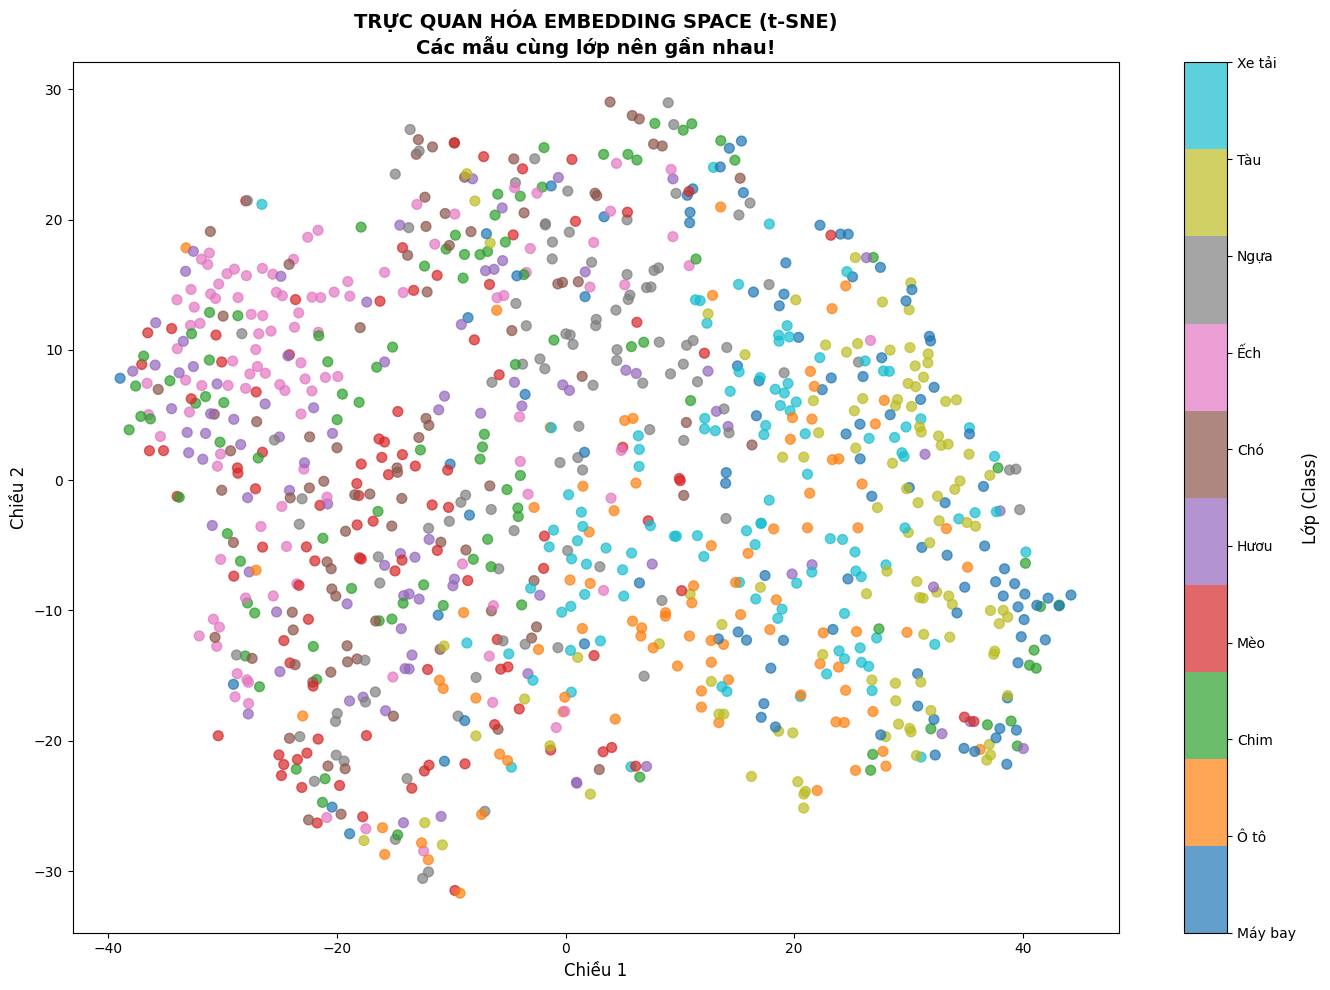


KẾT QUẢ:
- Các điểm CÙNG MÀU (cùng lớp) có xu hướng NHÓM LẠI với nhau
- Điều này cho thấy Encoder đã học được đặc trưng có ý nghĩa!


In [ ]:
# === GIẢM CHIỀU VỚI t-SNE VÀ VISUALIZE ===

print("Đang chạy t-SNE (có thể mất vài phút)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)
print("Hoàn tất t-SNE!")

# Tên các lớp trong CIFAR-10
class_names = ['Máy bay', 'Ô tô', 'Chim', 'Mèo', 'Hươu',
               'Chó', 'Ếch', 'Ngựa', 'Tàu', 'Xe tải']

# Vẽ biểu đồ
plt.figure(figsize=(14, 10))

# Scatter plot với màu theo label
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=labels,
    cmap='tab10',
    alpha=0.7,
    s=50
)

# Colorbar với tên lớp
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.ax.set_yticklabels(class_names)
cbar.set_label('Lớp (Class)', fontsize=12)

plt.title('TRỰC QUAN HÓA EMBEDDING SPACE (t-SNE)\n'
          'Các mẫu cùng lớp nên gần nhau!', fontsize=14, fontweight='bold')
plt.xlabel('Chiều 1', fontsize=12)
plt.ylabel('Chiều 2', fontsize=12)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KẾT QUẢ:")
print("- Các điểm CÙNG MÀU (cùng lớp) có xu hướng NHÓM LẠI với nhau")
print("- Điều này cho thấy Encoder đã học được đặc trưng có ý nghĩa!")
print("="*60)

---
## 8. Tổng kết

### Các thành phần chính của Contrastive Learning:

| Thành phần | Chức năng | Đầu ra |
|------------|-----------|--------|
| **Data Augmentation** | Tạo positive pairs từ 1 ảnh | (view_1, view_2) |
| **Encoder f(x)** | Trích xuất đặc trưng | h (dùng cho downstream) |
| **Projection Head g(h)** | Chiếu sang embedding | z (chỉ dùng khi training) |
| **InfoNCE Loss** | Kéo positive gần, đẩy negative xa | Loss value |

---

### Nguyên lý cốt lõi:

```
POSITIVE PAIRS (cùng ảnh)    --> Độ tương đồng CAO  --> Kéo LẠI GẦN
NEGATIVE PAIRS (khác ảnh)    --> Độ tương đồng THẤP --> Đẩy RA XA
```

---

### Quy trình sử dụng:

1. **Pre-training (Pretext Task):**
   - Huấn luyện với Contrastive Loss
   - KHÔNG cần nhãn dữ liệu!

2. **Fine-tuning (Downstream Task):**
   - Bỏ Projection Head g(.)
   - Dùng Encoder f(.) cho các tác vụ cụ thể
   - Ví dụ: Phân loại, phát hiện vật thể, phân đoạn ảnh

---

### Các Framework nổi tiếng:

| Framework | Đặc điểm chính |
|-----------|---------------|
| **SimCLR** | Batch size lớn, end-to-end đơn giản |
| **MoCo** | Memory Queue + Momentum Encoder |
| **BYOL** | Không cần negative pairs |
| **SimSiam** | Đơn giản nhất, dùng stop-gradient |

In [ ]:
print("="*60)
print("       DEMO CONTRASTIVE LEARNING HOÀN TẤT!")
print("="*60)
print("\nCảm ơn đã theo dõi!")

       DEMO CONTRASTIVE LEARNING HOÀN TẤT!

Cảm ơn đã theo dõi!
